In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import pearsonr
from scipy.stats import f_oneway

## EEG montage visualization

In [2]:
# 8 channels from 10-20 montage system.
channels = [
    # frontal
    'Fz',
    # central and temporal
    'C3',
    'Cz',
    'C4',
    # parietal
    'Po7',
    'Pz',
    'Po8',
    # occipital
    'Oz',
]

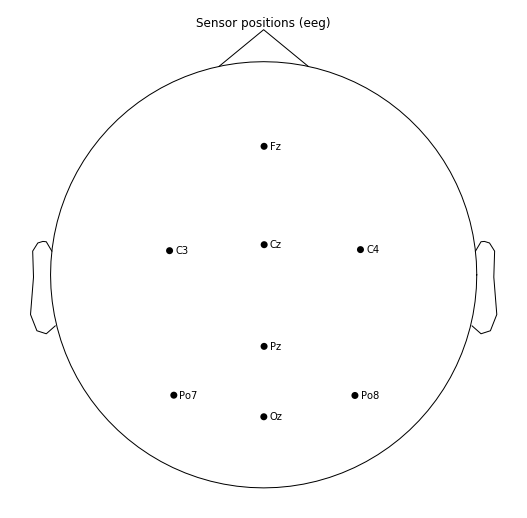

In [3]:
# plot EEG montage

def rename_ch(ch_old):
    if ch_old[-2] == '.':
        return ch_old[:-2]
    else:
        return ch_old[:-1]

sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)
sample.rename_channels(rename_ch)
sample = sample.pick_channels(channels)
ch_map = {ch.lower(): ch for ch in sample.ch_names}
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]
sample.set_montage(ten_twenty_montage)

# plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sample.plot_sensors(show_names=True, axes=ax)
plt.show()

## Data loader

#### 3 experiments were conducted generating 7 files for each subject:
01. Speaking_interacting;
02. Speaking_alone;
03. Pong_Playing against each other;
04. Pong_Playing against PC;
05. CSGO_Playing against each other;
06. CSGO_Playing together against PC;
07. CSGO_Playing alone against PC;

#### It is necessary to compare subjects' brain activity in experiments:
- 01 vs 02
- 03 vs 04
- 05 vs 07
- 06 vs 07

In [4]:
# function get_data receives an array of size (2,) such as [3, 4]
# it loads data of experiments with the corresponding indices for both subjects and returns data matrices
# input: exps - an array of size (2,) such as [3, 4], which contrains indices of the experiments
#        root_data_folder - path of the folder, which contains mat files with preprocessed data
def get_data(exps, root_data_folder = 'HS_data_preprocessed/'):
    
    # list subject folders
    folders = os.listdir(root_data_folder)
    sub_folders = [root_data_folder + folders[i] + '/' for i in range(len(folders)) if folders[i] != '.DS_Store']
    
    # get files paths
    num_exp = 7
    sub1_file_paths, sub2_file_paths = np.sort(os.listdir(sub_folders[0])), np.sort(os.listdir(sub_folders[1]))
    sub1_file_paths = [sub_folders[0] + sub1_file_paths[i] for i in range(num_exp)]
    sub2_file_paths = [sub_folders[1] + sub2_file_paths[i] for i in range(num_exp)]
    sub_file_paths = [sub1_file_paths, sub2_file_paths]
    sub1_path, sub1_ref_path = sub_file_paths[0][exps[0]-1], sub_file_paths[0][exps[1]-1]
    sub2_path, sub2_ref_path = sub_file_paths[1][exps[0]-1], sub_file_paths[1][exps[1]-1]
    
    # loading data from mat files (preprocessed data)
    sub1_data, sub1_ref_data = scipy.io.loadmat(sub1_path), scipy.io.loadmat(sub1_ref_path)
    sub2_data, sub2_ref_data = scipy.io.loadmat(sub2_path), scipy.io.loadmat(sub2_ref_path)
    sub1_data, sub1_ref_data = sub1_data["EEG"][0][0][15], sub1_ref_data["EEG"][0][0][15]
    sub2_data, sub2_ref_data = sub2_data["EEG"][0][0][15], sub2_ref_data["EEG"][0][0][15]

    # cut data for each subject to have the same number of time samples in data matrices
    ts1, ts1_ref, ts2, ts2_ref = np.size(sub1_data, 1), np.size(sub1_ref_data, 1), np.size(sub2_data, 1), np.size(sub2_ref_data, 1)
    ts1_new, ts2_new = min(ts1, ts1_ref), min(ts2, ts2_ref)
    sub1_data, sub1_ref_data = sub1_data[:, :ts1_new], sub1_ref_data[:, :ts1_new]
    sub2_data, sub2_ref_data = sub2_data[:, :ts2_new], sub2_ref_data[:, :ts2_new]
    
    return sub1_data, sub1_ref_data, sub2_data, sub2_ref_data

In [5]:
# example: load data
exp_pairs = [[1, 2], [3, 4], [5, 7], [6, 7]]
for exp_pair in exp_pairs:
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)

## Replication of the analysis pipeline described in the paper [3].

In [53]:
# function compare_exps is based on the analysis pipeline described in [3]. 
# it takes data for two subjects recorded in interactive and reference experiments. Data is split 
# into overlapping windows first. Next, correlation are found for data matrices of two subjects. 
# Correlations are calculated for each pair of channels and for each window. This way, matrices R and R_ref
# are obtained for interactive and reference experiments respectively.
# Finally, p-value is calculated between vectors of R and R_ref in order to find statistically significant
# differences between the experiments.
# input: sub1, sub1_ref - data matrices for the first subject recorded in the interactive and reference experiments
#        sub2, sub2_ref - data matrices for the second subject recorded in the interactive and reference experiments
#        window_s - size of the window in seconds
#.       stride_s - size of the overlap in seconds
#.       sampling_rate - sampling rate of the EEG acquisition system
#        p_th - threshold p-value, if p is lower than the threshold, then feature distribution is visualized
def compare_exps(sub1, sub1_ref, sub2, sub2_ref, window_s=5, stride_s=2.5, sampling_rate=250, p_th=0.005):
    
    # calculate sizes of window and stride in time samples
    window, stride = int(window_s*sampling_rate), int(stride_s*sampling_rate)
    
    # cut data to have the same number of samples for both subjects
    ts1, ts2 = np.size(sub1, 1), np.size(sub2, 1)
    ts_new = min(ts1, ts2)
    sub1, sub1_ref, sub2, sub2_ref = sub1[:, :ts_new], sub1_ref[:, :ts_new], sub2[:, :ts_new], sub2_ref[:, :ts_new]
    
    # get parameters, i.e. number of channels, number of time samples, number of windows
    n_ch = np.size(sub1, 0)
    n_ts = np.size(sub1, 1)
    n_windows = len(range(0, n_ts - window, stride))
    
    # create matrices that will contain windowed data
    sub1_resh, sub1_ref_resh = np.zeros((n_ch, window, n_windows)), np.zeros((n_ch, window, n_windows))
    sub2_resh, sub2_ref_resh = np.zeros((n_ch, window, n_windows)), np.zeros((n_ch, window, n_windows))
    
    # iterate over windows and fill in the matrices
    for w_idx, w_start in enumerate(range(0, n_ts - window, stride)):
        sub1_cut, sub1_ref_cut = sub1[:, w_start:w_start+window], sub1_ref[:, w_start:w_start+window]
        sub2_cut, sub2_ref_cut = sub2[:, w_start:w_start+window], sub2_ref[:, w_start:w_start+window]
        sub1_resh[:, :, w_idx], sub1_ref_resh[:, :, w_idx] = sub1_cut, sub1_ref_cut
        sub2_resh[:, :, w_idx], sub2_ref_resh[:, :, w_idx] = sub2_cut, sub2_ref_cut
    
    # initialize matrices R and R_ref, which will contain correlation coefficients 
    # between signals for various channels
    R, R_ref = np.zeros((n_ch, n_ch, n_windows)), np.zeros((n_ch, n_ch, n_windows))
    
    p_pr, p_pr_ref = np.zeros((n_ch, n_ch, n_windows)), np.zeros((n_ch, n_ch, n_windows))
    # iterate over windows and channels and fill in the matrices R and R_ref
    for w_idx in range(n_windows):
        for ch1 in range(n_ch):
            for ch2 in range(n_ch):
                sub1_vec, sub1_ref_vec = sub1_resh[ch1, :, w_idx], sub1_ref_resh[ch1, :, w_idx]
                sub2_vec, sub2_ref_vec = sub2_resh[ch2, :, w_idx], sub2_ref_resh[ch2, :, w_idx]
                R[ch1, ch2, w_idx], p_pr[ch1, ch2, w_idx] =  pearsonr(sub1_vec, sub2_vec)#[0]
                R_ref[ch1, ch2, w_idx], p_pr_ref[ch1, ch2, w_idx] = pearsonr(sub1_ref_vec, sub2_ref_vec)#[0]
    
#     print('Pearson coef average p-value for the interactive experiment: ', np.mean(p_pr))
#     print('Pearson coef average p-value for the reference experiment: ', np.mean(p_pr_ref))
    
    # iterate over channels to compare feature vectors in an interactive experiment and a reference expreiment
    for ch1 in range(n_ch):
        for ch2 in range(n_ch):
            feat_vec, feat_vec_ref = R[ch1, ch2, :], R_ref[ch1, ch2, :]
            F, p = f_oneway(feat_vec, feat_vec_ref)
            if p < p_th:
                visualize_hist(feat_vec, feat_vec_ref, ch1, ch2, round(p,-int(np.log10(p_th))+1))

In [54]:
def visualize_hist(v1, v2, ch1, ch2, p):
    plt.figure(figsize=(10,7))
    plt.title('Feature distribution, interaction vs. reference, channels ' + str(ch1) + ' and ' + str(ch2) + ', p = ' + str(p))
    sns.kdeplot(v1, shade=True, label = 'interacting')
    sns.kdeplot(v2, shade=True, label = 'reference')
    plt.grid()
    plt.legend()
    plt.show()

### Epxerimen1: Speaking together vs Speaking alone

Comparison of two experiments: Speaking together vs Speaking alone


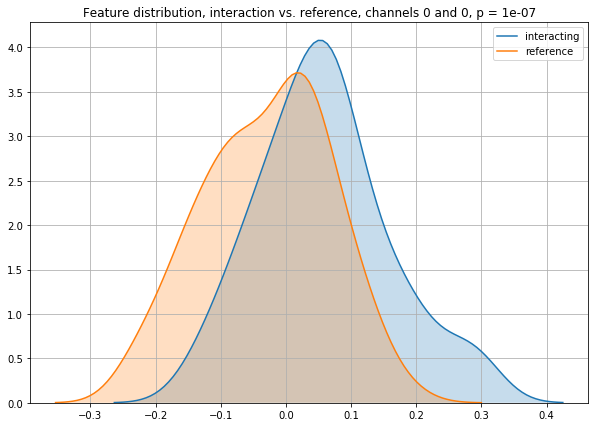

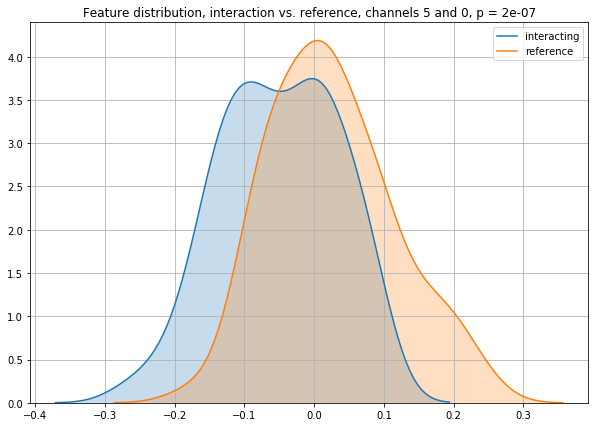

In [55]:
exp_pairs = [[1, 2]]
#p_th_array = [1e-3, 2e-3, 5e-3, 5e-3]
p_th_array = [1e-6]

exp_names = ["Speaking together vs Speaking alone"]

for idx, exp_pair in enumerate(exp_pairs):
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)
    print('Comparison of two experiments: ' + exp_names[idx])
    compare_exps(sub1, sub1_ref, sub2, sub2_ref, p_th=p_th_array[idx])
    print('')

### Experiment 2: Playing pong against each other vs Playing alone against PC

Comparison of two experiments: Playing pong against each other vs Playing alone against PC


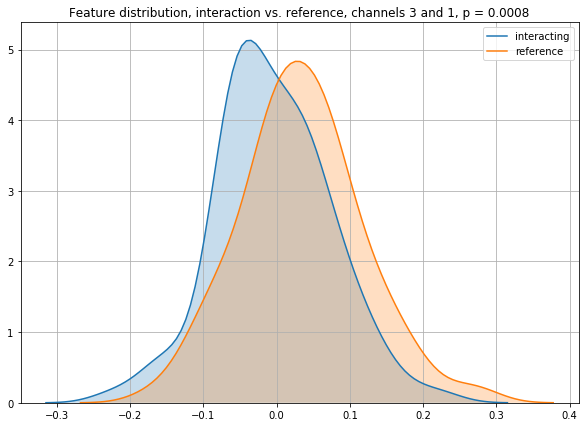

In [56]:
exp_pairs = [[3, 4]]
p_th_array = [1e-3]

exp_names = ["Playing pong against each other vs Playing alone against PC"]

for idx, exp_pair in enumerate(exp_pairs):
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)
    print('Comparison of two experiments: ' + exp_names[idx])
    compare_exps(sub1, sub1_ref, sub2, sub2_ref, p_th=p_th_array[idx])
    print('')

### Experiment 3: Playing CS:GO against each other vs Playing alone against PC

Comparison of two experiments: Playing CS:GO against each other vs Playing alone against PC


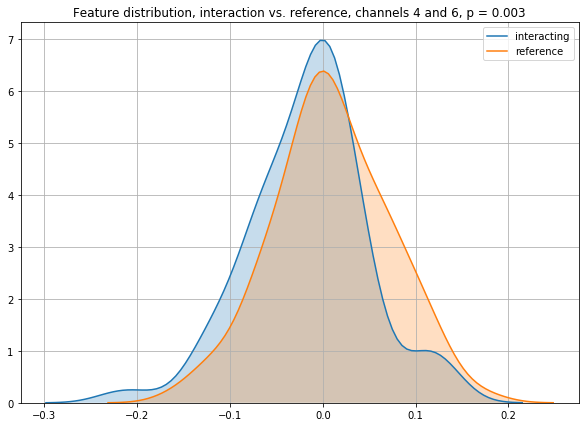

In [57]:
exp_pairs = [[5, 7]]
p_th_array = [5e-3]

exp_names = ["Playing CS:GO against each other vs Playing alone against PC"]

for idx, exp_pair in enumerate(exp_pairs):
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)
    print('Comparison of two experiments: ' + exp_names[idx])
    compare_exps(sub1, sub1_ref, sub2, sub2_ref, p_th=p_th_array[idx])
    print('')

### Experiment 4: Playing CS:GO together against PC vs Playing alone against PC

Comparison of two experiments: Playing CS:GO together against PC vs Playing alone against PC


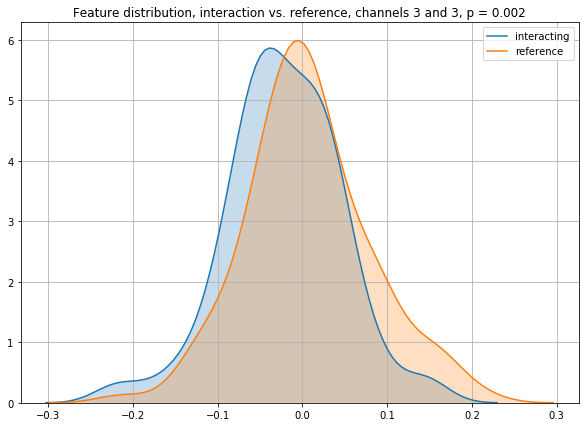

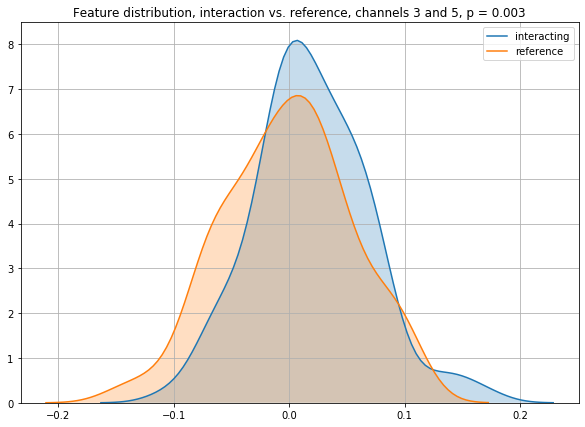

In [58]:
exp_pairs = [[6, 7]]
p_th_array = [5e-3]

exp_names = ["Playing CS:GO together against PC vs Playing alone against PC"]

for idx, exp_pair in enumerate(exp_pairs):
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)
    print('Comparison of two experiments: ' + exp_names[idx])
    compare_exps(sub1, sub1_ref, sub2, sub2_ref, p_th=p_th_array[idx])
    print('')

## References

[1] Czeszumski A., et al., “Hyperscanning: A Valid Method to Study Neural Inter-brain Underpinnings of Social Interaction”, 2020;

[2] Balconi M., Vanutelli M., “Cooperation and Competition with Hyperscanning Methods: Review and Future Application to Emotion Domain”, 2017;

[3] Sinha N., et al., “EEG hyperscanning study of inter-brain synchrony during cooperative and competitive interaction”, 2016;

[4] Astolfi L., et al., “Imaging the Social Brain by Simultaneous Hyperscanning During Subject Interaction”, 2011;

[5] Astolfi L., et al., “Study of the Functional Hyperconnectivity between Couples of Pilots during Flight Simulation: an EEG Hyperscanning Study”, 2011;

[6] Babiloni F., et al., “High Resolution EEG Hyperscanning During a Card Game”, 2007;

[7] Stone D., et al., “Hyperscanning of Interactive Juggling: Expertise Influence on Source Level Functional Connectivity”, 2019;

[8] Sangtae A., et al., "Interbrain phase synchronization during turn‐taking verbal interaction—a hyperscanning study using simultaneous EEG/MEG", 2017.